<a href="https://colab.research.google.com/github/Agrim-1711/MachineLearningProjects/blob/main/Temperature_HMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

I previously created a machine learning model using **linear regression** to predict Temperature based on a combination of other weather data.

Now, I aim to implement concepts I learned in my university's Machine Learning and Real-world Data (MLRD) course to create a new machine learning model that instead uses a **Hidden Markov Model** (HMM).

I will later compare these two models.

# Plan

I am going to use the temperature and precipitation data from 2015 May in Camborne to train the model. Then input the precipitation data from June-October which will then output the predicted temperatures for that period.

To do this, I will define the parameters of my hidden markov model

*   Hidden states - Temperature (cold, mild or hot)
*   Observations - Precipitation (none/little, light/moderate or heavy)
*   Transition probabilities - Chances of going from one hidden state to the next
*   Emission probabilities - Chances of going from a hidden state to an observation




# Installing/Importing libraries

In [ ]:
!pip install hmmlearn
import numpy as np
import pandas as pd
from hmmlearn import hmm
from matplotlib import pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 3.2 MB/s eta 0:00:00


# Code for loading data from Excel file

Training data is May 2015 Camborne

In [ ]:
pd.options.display.max_rows = 5
pd.options.display.float_format = "{:.1f}".format
training_df = pd.read_excel('/content/sample_data/DataSet.xls',sheet_name=6,header=None,skiprows=6,usecols='A:O',nrows=31)

# Training data cleanup

Including replacing trace values with 0.025

In [ ]:
training_df.columns = ["Date","Temperature","Rainfall","Sunshine","Windspeed","Windspeed_Beaufort","Gust_kn","Humidity","Cloud","Visibility","Pressure","Wind_Direction","Cardinal_Direction","Max_Gust","Cardinal_Direction2"]
training_df["Rainfall"] = training_df["Rainfall"].replace("tr", 0.025)
training_df = training_df.replace(np.nan, 0)

training_df["Visibility"] /= 200
training_df["Pressure"] /= 100
training_df["Humidity"] /= 10

print(training_df.head())

        Date  Temperature  Rainfall  Sunshine  Windspeed Windspeed_Beaufort  \
0 2015-05-01          9.6       3.4       0.0         14           Moderate   
1 2015-05-02         10.8      13.2       0.0         13           Moderate   
2 2015-05-03         12.3       0.2       0.4         13           Moderate   
3 2015-05-04          9.8      12.8       3.8          9              Light   
4 2015-05-05         10.8       2.2       5.2         18              Fresh   

   Gust_kn  Humidity  Cloud  Visibility  Pressure  Wind_Direction  \
0       33       9.5      8        10.0      10.1             110   
1       37      10.0      8         2.5      10.0             150   
2       29      10.0      8         3.0      10.0             240   
3       23       9.9      6         5.0      10.0             140   
4       43       9.9      6         5.5       9.9             240   

  Cardinal_Direction  Max_Gust Cardinal_Direction2  
0                ESE       110                 ESE  
1   

# Prepare data for HMM

Temperature values are the hidden states and Rainfall values are the observations.
We need to convert these numerical values into the discrete categories:
*   Temperature - cold(0), mild(1), warm/hot(2)
*   Rainfall - none/little(0), light/moderate(1), heavy(2)





In [ ]:
def categorise_temp(t):
    if t <= 10:
        return 0   # cold
    elif 10 < t <= 20:
        return 1   # mild
    else:   # t > 20
        return 2   # warm/hot

training_df['Temp_State'] = training_df['Temperature'].apply(categorise_temp)

def categorise_rainfall(r):
    if r <= 0.1:
        return 0   # none/little
    elif 0.1 < r <= 4:
        return 1   # light/moderate
    else:   # r > 4
        return 2   # heavy

training_df['Rainfall_State'] = training_df['Rainfall'].apply(categorise_rainfall)

# Define and train HMM

In [ ]:
# Observations (precipitation)
X = np.array(training_df['Rainfall_State']).reshape(-1, 1)

# Hidden states (temperature)
y = np.array(training_df['Temp_State'])

model = hmm.MultinomialHMM(n_components=3, n_iter=500, tol=1e-7)
model.fit(X)

https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


MultinomialHMM(n_components=3, n_iter=500,
               n_trials=array([1, 2, 1, 2, 1, 0, 1, 2, 0, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 2, 1]),
               random_state=RandomState(MT19937) at 0x7EFEF2391E40, tol=1e-07)

# Clean and prepare training data

Data from June to October 2015 for Camborne

In [ ]:
testing_df = pd.read_excel('/content/sample_data/DataSet.xls', sheet_name=6, header=None, skiprows=37, usecols='A:O', nrows=153)
testing_df.columns = ["Date","Temperature","Rainfall","Sunshine","Windspeed","Windspeed_Beaufort","Gust_kn","Humidity","Cloud","Visibility","Pressure","Wind_Direction","Cardinal_Direction","Max_Gust","Cardinal_Direction2"]

# Process and categorise rainfall data for prediction
testing_df["Rainfall"] = testing_df["Rainfall"].replace("tr", 0.025)
testing_df = testing_df.replace(np.nan, 0)
testing_df['Rainfall_State'] = testing_df['Rainfall'].apply(categorise_rainfall)

# Predict temperatures based on rainfall data

In [ ]:
# Predict temperatures based on rainfall states
X_test = np.array(testing_df['Rainfall_State']).reshape(-1, 1)
predicted_temperatures = model.predict(X_test)

# Convert temperature states back to readable format
def state_to_temperature(state):
    if state == 0:
        return 'Cold'
    elif state == 1:
        return 'Mild'
    else:
        return 'Hot'

predicted_temp_labels = [state_to_temperature(state) for state in predicted_temperatures]

# Add predicted temperatures to the dataframe
testing_df['Predicted_Temperature'] = predicted_temp_labels

print(testing_df[['Date', 'Rainfall', 'Predicted_Temperature']].head())

        Date  Rainfall Predicted_Temperature
0 2015-06-01      19.0                  Cold
1 2015-06-02       0.2                   Hot
2 2015-06-03       0.0                  Mild
3 2015-06-04       0.0                  Mild
4 2015-06-05       0.0                  Mild


# Comparing predictions to actual data

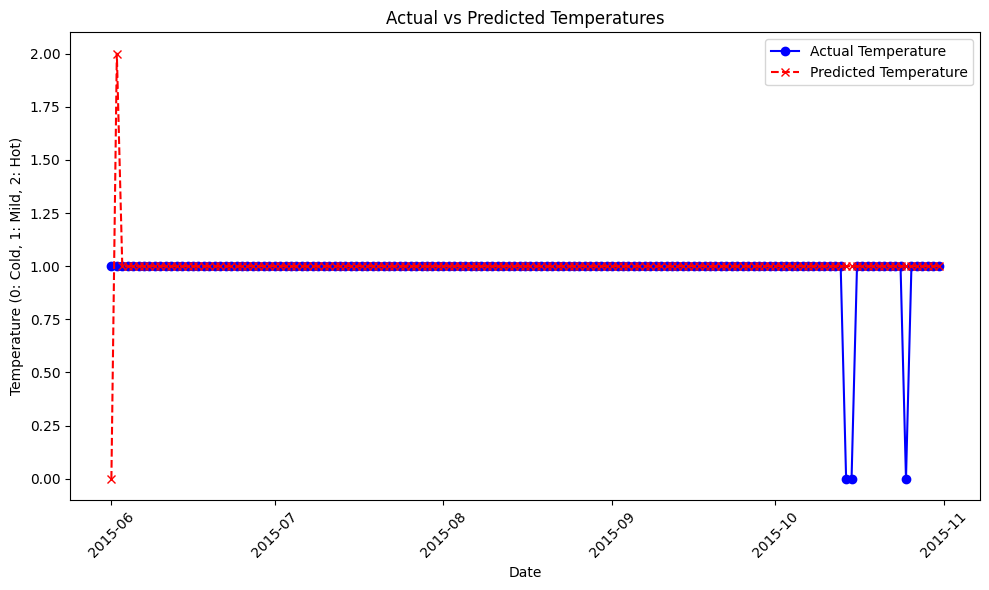

        Date  Rainfall  Temperature Predicted_Temperature
0 2015-06-01      19.0         10.7                  Cold
1 2015-06-02       0.2         13.2                   Hot
2 2015-06-03       0.0         12.2                  Mild
3 2015-06-04       0.0         12.0                  Mild
4 2015-06-05       0.0         12.1                  Mild


In [ ]:
# Map actual temperatures to readable format (assuming actual temperature states are available)
testing_df['Actual_Temp_State'] = testing_df['Temperature'].apply(categorise_temp)

# Plot the results: Actual vs Predicted
plt.figure(figsize=(10, 6))

# X-axis: Date
dates = pd.to_datetime(testing_df['Date'])

# Convert categorical temperature states to numeric for plotting
temp_mapping = {'Cold': 0, 'Mild': 1, 'Hot': 2}
predicted_numeric = [temp_mapping[temp] for temp in testing_df['Predicted_Temperature']]
actual_numeric = [temp_mapping[state_to_temperature(state)] for state in testing_df['Actual_Temp_State']]

# Plot actual temperatures
plt.plot(dates, actual_numeric, label="Actual Temperature", color='blue', marker='o')

# Plot predicted temperatures
plt.plot(dates, predicted_numeric, label="Predicted Temperature", color='red', linestyle='--', marker='x')

# Customize plot
plt.title('Actual vs Predicted Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature (0: Cold, 1: Mild, 2: Hot)')
plt.xticks(rotation=45)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

# Print first few rows for reference
print(testing_df[['Date', 'Rainfall', 'Temperature', 'Predicted_Temperature']].head())


# Evaluation

The results are promising and highly accurate for predicting temperature state.

This is shown by the fact that the model recovers from the initial high rainfall on the first day in June to predict mild temperature for most of the rest of the days.

The model does not get 'stuck' at an incorrect temperature state or constantly alternate between two states.

However, we have used a high number of iterations and a low tolerance level so it is possible the model is 'overfitted' to this particular training data. To check this, let's run this model on data for Camborne from a different year.